# Week 8 - Indexing 

In this lab you'll implement some methods for genome indexing: hash tables and tries.

Note that since we're using algorithms that are of size $O(m^2)$ (suffix tries rather than suffix trees), and representing tries with high-level data structures, we won't fit realistic genome sizes into memory. However we should achieve fast lookup.

If you want to be able to draw the tries, you need the graphviz package. If using your own computer, you may need to install the graphviz package with either

    conda install -c conda-forge python-graphviz
    
or

    pip install graphviz
    
Using `pip` will probably require you to have the graphviz command-line tool already installed.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from collections import defaultdict
import itertools
import graphviz

In [3]:
import skbio

In [4]:
from trie_utilities import draw_trie

## Data 

Strings in lectures:

In [5]:
text1 = "CGTGCGTGCTT"

In [6]:
text2 = "GTTATAGCTGATCGCGGCGTAGCGG"

The first 1000 base-pairs of the viral genome, phiX:

In [17]:
# Import with skbio and convert to just a string
phiX = str(skbio.DNA.read('data/phi-X174-1000bp.fa'))

In [18]:
# Or read it ourselves, assuming a file with one FASTA record
with open('data/phi-X174-1000bp.fa') as f:
    _identifier_row = f.readline()
    # Read the rest of the lines and join them into one string
    phiX = ''.join([row.strip() for row in f.readlines()])

## Generators and iterators

We're going to introduce a new kind of Python object - generators - in order to generate large number of strings without occupying a lot of memory.

You already know that we can iterate over lists:

In [ ]:
for x in [1,3,5]:
    print(x)

We can also iterate over other data types, like sets and dicts. Any type we can iterate over is *iterable*.

*Generators* and *iterators* are special kinds of Python object that are iterable, but which don't need to store any contents in memory. Instead they calculate each value on request.

(A generator is a particular kind of iterator, but for this tutorial we are not going to worry about the difference between them.)

We can make an example iterator using `iter()` on a data structure:

In [ ]:
number_iterator = iter([1,3,5])
print(number_iterator)

We can iterate over this just like the original list:

In [ ]:
for x in number_iterator:
    print(x)

The built-in `next()` function gets the next value from an iterator

In [ ]:
number_iterator = iter([1,3,5])

In [ ]:
next(number_iterator)

In [ ]:
next(number_iterator)

What do you think would happen if we ran our `for` loop now, i.e. tried to iterate with 

`for x in number_iterator` ?

In [ ]:
for x in number_iterator:
    print(x)

More usefully, we can create a generator using a generator function. This means we never need to store all the objects in memory. A generator function is easy to recognise as it uses the `yield` keyword rather than the `return` keyword to return values.

Here's a (normal) function that returns a list of k-mers.

In [ ]:
def get_kmers_list(text, k):
    ''' 
    Return a list of all k-mers of length k from string t.
    K-mers may be non-unique.
    '''
    result = []
    for i in range(len(text)-k+1):
        kmer = text[i:i+k]
        result.append(kmer)
    return result

In [ ]:
get_kmers_list('BANANA', 3)

Here's a *generator function* that returns all the k-mers in the string, but only calculates each one as it is asked for. Every time the function reaches the `yield` keyword, it makes a new value available, which is consumed by whatever we are using to iterate, such as a `for` loop. At no point do we need to store the whole list of k-mers in memory!

In [ ]:
def get_kmers_iterator(text, k):
    ''' 
    Return a generator yielding all k-mers of length k from string t.
    K-mers may be non-unique.
    '''
    result = []
    for i in range(len(text)-k+1):
        kmer = text[i:i+k]
        yield kmer

Notice we yield the kmers one at a time. We don't try to return the whole list at once. There is no list!

Every time `next()` is called on our generator, either by a `for` loop or some other means, the function resumes running from where it left off and runs until it gets to a `yield` statement.

This gives us a generator, which is iterable:

In [ ]:
for kmer in get_kmers_iterator('BANANA',3):
    print(kmer)

In [ ]:
# There is no list
print(get_kmers_iterator('BANANA', 3))

We can still assign the generator to a variable (if we want to)

In [ ]:
kmers = get_kmers_iterator('BANANA', 3)
print(kmers)

Unlike with a list, Python can't tell us how many k-mers are going to be returned in total, as it hasn't built a list - it doesn't know what any of the k-mers are yet.

In [ ]:
len(kmers)

In [ ]:
next(kmers)

In [ ]:
for kmer in kmers:
    print(kmer)

This concept is very useful if we want to iterate over large number of k-mers or suffixes and store them in a more concise data structure, and don't want to hold them all in memory in the meantime.

The itertools module provides lots of handy iterators, and ways to create them. E.g.:

In [ ]:
yesno_forever = itertools.cycle(['yes', 'no'])
count = 0
for x in yesno_forever:
    print(x)
    count += 1
    if count > 5:
        # This gets us out of the for loop
        break

`enumerate()` can also work with iterators:

In [ ]:
kmers = get_kmers_iterator('BANANA', 3)
for (i, kmer) in enumerate(kmers):
    print(i, kmer)

## Kmer index via hash table

**Exercise 1:**

Write a function which, given a text string and a value k, builds a k-mer index using a Python dict as a hash table. The keys of the dictionary should be the unique k-mers, and the values should be lists of positions in the text string where the k-mer can be found. 

Note that you don't need to worry about collisions - the `dict` type takes care of all the details of the hash table.

In [25]:
def kmer_index(text, k):
    ''' 
    Given a text string and integer k, build a dict of lists representing
    a k-mer index.
    '''
    index = defaultdict(list)
    for (i,kmer) in enumerate(get_kmers_iterator(text, k)):
        index[kmer].append(i)
    # return a dict rather than a defaultdict
    return dict(index)

In [26]:
# {'BA': [0], 'AN': [1, 4], 'ND': [2], 'DA': [3], 'NA': [5]}
kmer_index('BANDANA', 2)

{'BA': [0], 'AN': [1, 4], 'ND': [2], 'DA': [3], 'NA': [5]}

In [27]:
kmer_index(text1, 5)

{'CGTGC': [0, 4],
 'GTGCG': [1],
 'TGCGT': [2],
 'GCGTG': [3],
 'GTGCT': [5],
 'TGCTT': [6]}

In [28]:
phiX_index = kmer_index(phiX, 6)

In [29]:
# How many kmers in index?
# The smaller value we use for k, the less unique kmers we expect
len(phiX_index)

838

In [30]:
list(phiX_index.keys())[:5]

['GAGTTT', 'AGTTTT', 'GTTTTA', 'TTTTAT', 'TTTATC']

In [31]:
phiX_index['GAGTTT']

[0, 614]

## Suffixes 

**Exercise 2:**

Write a generator function `suffixes()` which, given a genome text, returns all tuples of the form `(i, suffix)` where `i` is a position in the genome text and `suffix` is the corresponding suffix string. Remember to append "$" to the text!

In [45]:
def suffixes(text):
    ''' 
    Given a text string, yield all suffixes and their genomic positions as tuples
    of the form (position, suffix)
    '''
    text += '$'
    for i in range(len(text)):
        yield (i, text[i:])

Should return
```
(0, 'BANANA$')
(1, 'ANANA$')
(2, 'NANA$')
(3, 'ANA$')
(4, 'NA$')
(5, 'A$')
(6, '$')
```

In [33]:
for s in suffixes('BANANA'):
    print(s)

0, (0, 'BANANA$')
(1, 'ANANA$')
(2, 'NANA$')
(3, 'ANA$')
(4, 'NA$')
(5, 'A$')
(6, '$')


## Suffix tries 

We're going to build tries that are intended to be used as suffix tries. We'll represent them as nested dictionaries. 

Any node will be represented by a dict where the dict keys are characters labelling the edges, and the dict values are the child nodes.

Since this is a suffix trie, the genomic indices we're looking up are only ever stored at leaf nodes, and the edge leading to a leaf node is always labelled with '$'. So we'll represent a leaf node and its incoming edge with a dict that looks like

```{'$':23}```

where the value in this leaf node represents the genomic coordinate we want to look up. 

Notice that we're only storing one integer value per leaf - this is fine for suffixes. Because of this, and because we've assumed the '$' character, we'd need a slightly different data structure for a k-mer trie index or for tries storing generic strings.

Here's an example trie storing only one string, 'A$', with value 6:

In [34]:
example_trie1 = {'A': {'$': 6}}

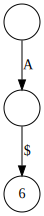

In [21]:
draw_trie(example_trie1)

Here's an example trie storing suffixes and index values `'AN$':6` and `'AAN$':5` (of course this cannot be a complete suffix trie - it only has two of the suffixes)

In [35]:
# nested-dict representation of trie that stores strings with values 
# 'AN$':[2,6] and 'AAN$':[5]
example_trie2 = {'A':{
                    'N': {'$': 6}, 
                    'A': {'N': {'$': 5}}
                    }
                }

In [36]:
example_trie2

{'A': {'N': {'$': 6}, 'A': {'N': {'$': 5}}}}

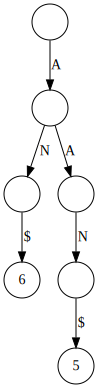

In [22]:
draw_trie(example_trie2)

**Exercise 3:**

Write a function which takes a trie, a string and an integer value, and adds the string to the trie, adding the value at the resulting leaf node.

In [37]:
def add_string(trie, keystring, value):
    '''
    Given a dict representing a trie, a key string, and an integer value,
    add the key string to the trie and add the value at the leaf node.
    The key string must be of at least length 1 and end with '$'.
    '''
    node = trie
    # Add all but the last character
    for char in keystring[:-1]:
        if char not in node:
            node[char] = {}
        node = node[char]
    # The last character must be a '$'
    assert keystring[-1]=='$'
    # Add the final node with key '$' and the given value
    node['$'] = value

In [38]:
# Should return
# {'a': {'b': {'a': {'$': 0}}, '$': 2}, 'b': {'a': {'$': 1}}, '$': 3}

# An empty trie is just an empty dict
aba_trie = dict()
add_string(aba_trie, 'aba$',0)
add_string(aba_trie, 'ba$',1)
add_string(aba_trie, 'a$',2)
add_string(aba_trie, '$',3)
aba_trie

{'a': {'b': {'a': {'$': 0}}, '$': 2}, 'b': {'a': {'$': 1}}, '$': 3}

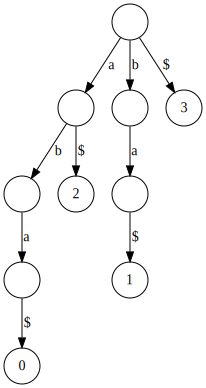

In [39]:
draw_trie(aba_trie)

In [40]:
test_trie = dict()
add_string(test_trie, 'anana$',1)
add_string(test_trie, 'ana$',3)
add_string(test_trie, 'a$',5)
add_string(test_trie, '$',6)
# We haven't added all the suffixes, but this trie will still work for display
# should return {'a': {'n': {'a': {'n': {'a': {'$': 1}}, '$': 3}}, '$': 5}, '$': 6}
test_trie

{'a': {'n': {'a': {'n': {'a': {'$': 1}}, '$': 3}}, '$': 5}, '$': 6}

In [41]:
# Only top-level edges are 'a' and '$'
len(test_trie)

2

**Exercise 4:**

Use your `suffixes()` generator function and your `add_string()` function to build a suffix trie.

In [43]:
def suffix_trie(text):
    ''' 
    Given a text string, return the suffix trie.
    '''
    trie = dict()
    for (pos, suffix) in suffixes(text):
        add_string(trie, suffix, pos)
    return trie

In [46]:
# {'a': {'b': {'a': {'$': 0}}, '$': 2}, 'b': {'a': {'$': 1}}, '$': 3}
suffix_trie('aba')

{'a': {'b': {'a': {'$': 0}}, '$': 2}, 'b': {'a': {'$': 1}}, '$': 3}

In [48]:
suffix_trie('banana')

{'b': {'a': {'n': {'a': {'n': {'a': {'$': 0}}}}}},
 'a': {'n': {'a': {'n': {'a': {'$': 1}}, '$': 3}}, '$': 5},
 'n': {'a': {'n': {'a': {'$': 2}}, '$': 4}},
 '$': 6}

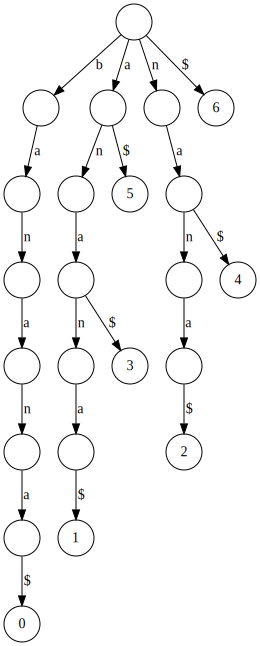

In [49]:
banana_trie = suffix_trie('banana')
draw_trie(banana_trie)

**Exercise 5:**

Write a function which returns True if a query string is in the genome represented by a suffix trie, and False if it is not. Remember we don't need to get to a leaf node, as it's ok if our query string is the prefix of one of the suffixes in a trie.

In [50]:
def query_trie_for_existence(trie, keystring):
    '''
    Given a dict representing a suffix trie, and a key string,
    return True if the key string is a prefix of any suffix in the trie,
    and False otherwise.
    '''
    node = trie
    for char in keystring:
        if char not in node:
            return False
        node = node[char]
    # We've followed the whole keystring
    return True

In [51]:
query_trie_for_existence(banana_trie, 'ana')

True

In [52]:
query_trie_for_existence(banana_trie, 'anab')

False

In [53]:
text2_trie = suffix_trie(text2)
query_trie_for_existence(text2_trie, 'GATCGC')

True

In [54]:
query_trie_for_existence(text2_trie, 'GAGCGC')

False

**Exercise 6 (challenge):**

Write a function which queries a suffix trie and returns either `None` (if the string is not in the trie at all) or a list of genomic coordinates (if it is).

To find all coordinates in the subtree of a given node, we need to carry out a depth-first search. To make this challenge a bit easier, you can import this function from trie_utilities with `from trie_utilities import get_leaf_values()`, which implements depth-first search, or you can write it yourself.

In [82]:
from trie_utilities import get_leaf_values

def query_trie(trie, keystring):
    '''
    Query given trie for keystring.
    If it is not found, return None.
    If it is found, return the list of genomic coordinates indexed by it.
    '''
    node = trie
    for char in keystring:
        if char not in node:
            print("String not found")
            return None
        node = node[char]
    # We've followed the whole keystring, get leaf values
    print("String found")
    return get_leaf_values(node) 

In [61]:
banana_trie = suffix_trie('banana')

In [62]:
query_trie(banana_trie, 'an')

[3, 1]

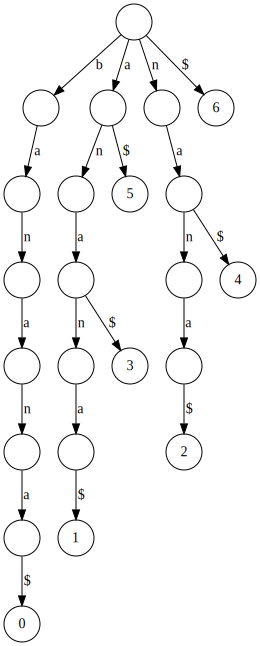

In [214]:
draw_trie(banana_trie)

In [58]:
phiX_trie = suffix_trie(phiX)

In [85]:
query_trie(phiX_trie, 'TAT')

String found


[6, 64, 346, 148, 42, 439, 709, 638, 619, 248, 282, 566, 641, 940]

In [86]:
query_trie(phiX_trie, 'TATTT')

String found


[42]

In [88]:
query_trie(phiX_trie, 'TATGGG')

String not found
